## PINN for DP using real data

### Import libraries and packages

In [3]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import scipy.io
import pandas as pd

2025-08-28 10:36:23.718683: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 10:36:23.720362: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 10:36:23.752097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 10:36:23.752886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-28 10:36:24.304365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Define the PINN model and train

In [ ]:
# Set up random seeds for replication of results
np.random.seed(seed=5923)
tf.random.set_seed(5923)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.sigmoid(tf.add(tf.matmul(A, W[i]), b[i]))  #BE CAREFUL on the choice of activation function (sigmoid in this case since we use the natural logarithm)
    Y = tf.abs(tf.add(tf.matmul(A, W[-1]), b[-1]))
    return Y

# Trainable variables (weights and biases of the network and the parameters to estimate
def train_vars(W, b, ln_lambda1, lambda2):
    return W + b + ln_lambda1 + lambda2

# Network for DP (u in the code)
def net_u(t, w, b):
    u = DNN(tf.concat([t],1), w, b)
    return u

# Network for the residual
@tf.function
def net_f(t,W, b, ln_lambda1, lambda2, DP_scale, t_scale, lb, ub):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net_u(t, W, b)
        u_log = tf.math.log(u)
    u_t = tape1.gradient(u_log, t)
    f = u_t + ln_lambda1 - lambda2 + 2*u_log + tf.math.log(DP_scale) + tf.math.log(t_scale)  #residual function
    return f

#Training function
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, opt, ln_lambda1, lambda2, R, T, DP_scale, t_scale, lb, ub):
    t = X_u_train_tf[:,0:1]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b,ln_lambda1,lambda2])
        u_nn = net_u(t, W, b) 
        f_nn = net_f(t, W, b, ln_lambda1, lambda2, DP_scale, t_scale, lb, ub)
        loss_data = tf.reduce_mean(tf.square(u_nn - u_train_tf))
        loss_f = tf.reduce_mean(tf.square(f_nn)) 
        loss = loss_data + loss_f  #loss function
    grads = tape.gradient(loss, train_vars(W,b, ln_lambda1, lambda2))
    opt.apply_gradients(zip(grads, train_vars(W,b,ln_lambda1, lambda2)))
    return loss, loss_data, loss_f, ln_lambda1, lambda2



N_u = 300    #Number of data points (could be also just initial and boundary conditions)
N_f = 200    #Number of collocation point
Nmax= 60000  #Number of epochs

#Define the parameters of the residual 
R = tf.convert_to_tensor(8.314*10**(-3), dtype=tf.float32)
T = tf.convert_to_tensor(322, dtype=tf.float32)    #Kelvin
DP_scale = tf.convert_to_tensor(100, dtype=tf.float32)  #scaling value for the intial condition
t_scale = tf.convert_to_tensor(365*24*35.27, dtype=tf.float32)  # scaling value for time

#Network architecture
layers = [1, 50, 50, 50, 1]

L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 
ln_lambda1 = [tf.Variable([19.0], dtype=tf.float32)]  #initialization of the scaled parameter A to estimate (ln_lambda1 = ln(A))
lambda2 = [tf.Variable([38.0], dtype=tf.float32)]     #initialization of the scaled parameter E to estimate (lambda2 = E/(RT))

# Dataset
df = pd.read_excel('./DP_measurements.xlsx')

# Data from real measurements
df_dp_real = df.drop(columns=['TF','FD','AF','M2F','CO2','CO'])  #we drop the columns from the dataset that we do not use
data1 = np.array(df_dp_real)
data_real = data1.astype(np.float32)

# Time and DP for real measurements
t_real = (data_real[:,0]/data_real[-1,0]).flatten()[:,None]  #data for time from the real measurement that we scale with the largest value
Exact_real = (data_real[:,1]/100).flatten()[:,None]   #data for the DP values that we scale by a factor of 100

# Flatten data
t_star = t_real.flatten()[:,None]
Exact_star = Exact_real.flatten()[:,None] 

# Domain bounds
lb = t_star.min(0)
ub = t_star.max(0)

#For this case the training data and the collocation points are the same, we just train with the data we have and do not sample more points
#idx = np.random.choice(t_star.shape[0], N_u, replace=False)  #this is the index used if we want to use less data points from the dataset, but not used in this case
X_u_train = t_star#[idx, :]
u_train = Exact_star#[idx,:]

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)  #convert to tensor
u_train_tf = tf.convert_to_tensor(u_train, dtype=tf.float32)      #convert to tensor

#Adam optimizer
lr = 1e-3
optimizer = tf.optimizers.legacy.Adam(learning_rate=lr)

#Training: We define empty lists to fill at each iteration with values for each loss function and estimated parameters
start_time = time.time()
n=0
loss = []
loss_data = []
loss_f = []
ln_lambda1_list = []
lambda2_list = []
while n <= Nmax:
    loss_, loss_data_, loss_f_, ln_lambda1_list_, lambda2_list_ = train_step(W, b, X_u_train_tf, u_train_tf, optimizer, ln_lambda1, lambda2, R, T, DP_scale, t_scale, lb, ub)
    loss.append(loss_.numpy())  
    loss_data.append(loss_data_.numpy())  
    loss_f.append(loss_f_.numpy()) 
    ln_lambda1_list.append(ln_lambda1_list_[0].numpy())
    lambda2_list.append(lambda2_list_[0].numpy())
    print(f"Iteration is: {n} and loss is: {loss_.numpy()} and lambda_1 is: {ln_lambda1_list_[0].numpy()} and lambda_2 is: {lambda2_list_[0].numpy()}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))


### PINN results

In [7]:
def predict(X_star_tf, w, b):
    t_star = X_star_tf[:,0:1]
    u_pred = net_u(t_star, w, b)
    return u_pred

t_star_tf = tf.convert_to_tensor(t_star.flatten()[:,None], dtype=tf.float32)    
u_pred = predict(t_star_tf, W, b)

#Error estimation
error_u = np.linalg.norm(Exact_star-u_pred,2)/np.linalg.norm(Exact_star,2)
print('Error u: %e' %(error_u)) 

Error u: 3.475876e-03


### PINN results compared to data

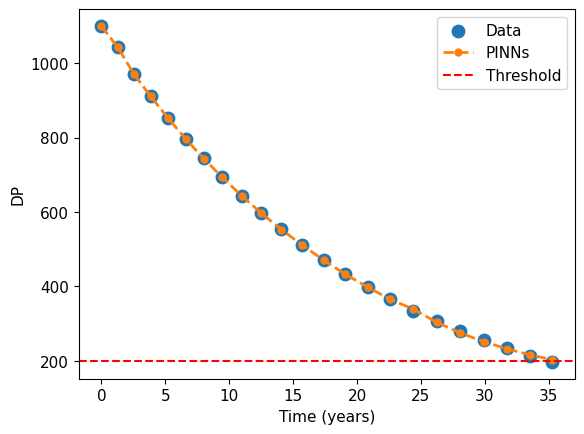

In [9]:
#fig = plt.figure(figsize=(6,4), dpi=150)
plt.scatter(t_star*data_real[-1,0],Exact_star*100, label='Data',color='tab:blue',s=80, zorder=0)
plt.plot(t_star*data_real[-1,0],u_pred*100, 'tab:orange', label='PINNs', marker='.', markersize=10, linewidth='2', linestyle='--', zorder=1)
plt.axhline(y=200, color='r', linestyle='--', label='Threshold')
plt.xticks(size=11)
plt.yticks(size=11)
plt.xlabel('Time (years)', size=11)
plt.ylabel('DP', size=11)
plt.legend(fontsize=11)
#plt.savefig('' + 'DP_pred_real' + '.pdf', format="pdf", bbox_inches="tight")

### Loss functions

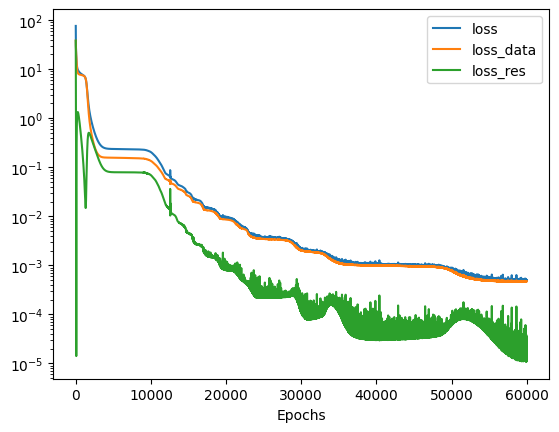

In [11]:
#fig = plt.figure(figsize=(5, 3), dpi=150)
p = np.shape(loss)
ep = np.arange(p[0])
plt.semilogy(ep,loss, label='loss')
plt.semilogy(ep,loss_data, label='loss_data')
plt.semilogy(ep,loss_f, label='loss_res')
plt.xlabel('Epochs')
plt.legend()
#plt.savefig('' + 'Losses_real' + '.pdf', format="pdf", bbox_inches="tight")

### Plot of evolution of parameters over the epochs and losses

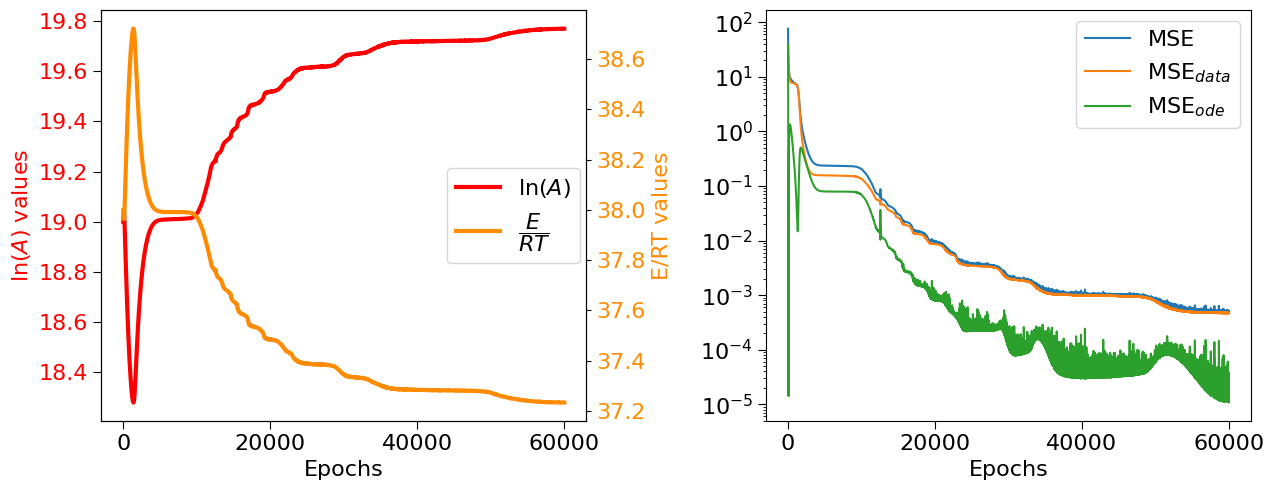

In [12]:
fig, axs = plt.subplots(1,2, figsize=(13,5))

p = np.shape(loss)
ep = np.arange(p[0])
axs[1].semilogy(ep,loss, label='MSE')
axs[1].semilogy(ep,loss_data, label=r'MSE$_{data}$')
axs[1].semilogy(ep,loss_f, label=r'MSE$_{ode}$')
axs[1].tick_params(axis='y', labelsize=16, length=6)
axs[1].tick_params(axis='x', labelsize=16, length=6)
axs[1].set_xlabel('Epochs', size=16)
axs[1].set_xticks(np.arange(0,60001,20000))
axs[1].legend(fontsize=16)

color = 'red'
axs[0].set_xlabel('Epochs', size=16)
axs[0].set_ylabel(r'ln($A$) values', color=color, size=16)
l1 = axs[0].plot(ln_lambda1_list, color=color, linewidth=3, label=r'ln($A$)')
axs[0].tick_params(axis='y', labelcolor=color, labelsize=16, length=6)
axs[0].tick_params(axis='x', labelsize=16, length=6)
axs[0].set_xticks(np.arange(0,60001,20000))

ax2 = axs[0].twinx()  # instantiate a second Axes that shares the same x-axis

color = 'darkorange'
ax2.set_ylabel('E/RT values', color=color, size=16)  # we already handled the x-label with ax1
l2 = ax2.plot(lambda2_list, color=color, linewidth=3, label= r'$\dfrac{E}{RT}$')
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)

lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center', bbox_to_anchor=(0.85,0.5), fontsize=16)

fig.tight_layout()
#plt.savefig('' + 'Params_losses_epochs_real' + '.pdf', format="pdf", bbox_inches="tight")

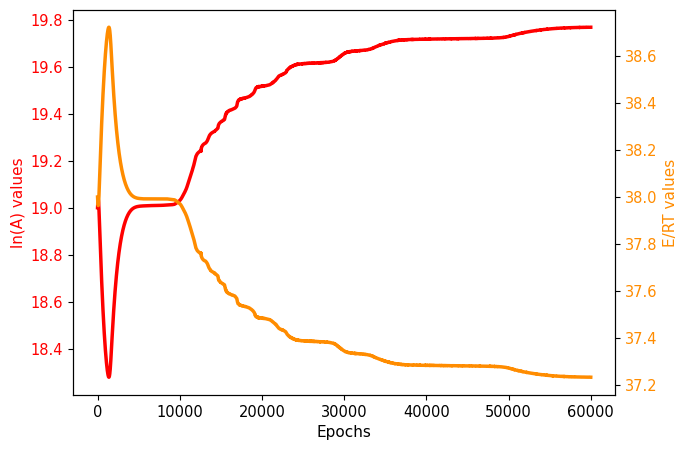

In [13]:
fig, ax1 = plt.subplots(figsize=(7,5))

color = 'red'
ax1.set_xlabel('Epochs', size=11)
ax1.set_ylabel('ln(A) values', color=color, size=11)
ax1.plot(ln_lambda1_list, color=color, linewidth=2.5)
ax1.tick_params(axis='y', labelcolor=color, labelsize=10.5)
ax1.tick_params(axis='x', labelsize=10.5)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'darkorange'
ax2.set_ylabel('E/RT values', color=color, size=11)  # we already handled the x-label with ax1
ax2.plot(lambda2_list, color=color, linewidth=2.5)
ax2.tick_params(axis='y', labelcolor=color, labelsize=10.5)

#plt.savefig('' + 'Parameters_evolution_real' + '.pdf', format="pdf", bbox_inches="tight")

Text(0, 0.5, 'ln(A) values')

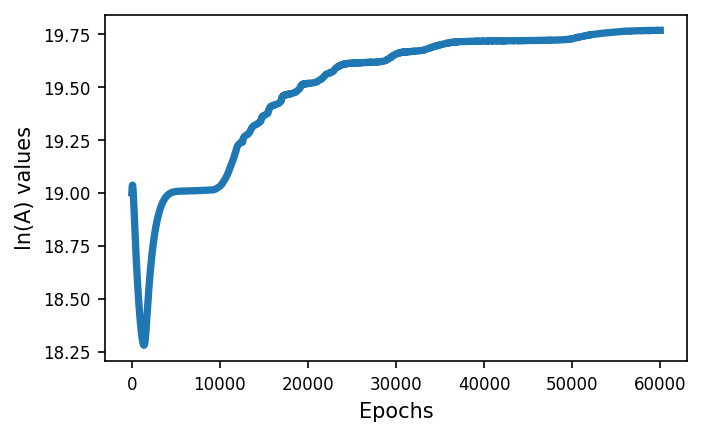

In [14]:
fig = plt.figure(figsize=(5, 3), dpi=150)
plt.plot(ln_lambda1_list, linewidth='3.5')
plt.xticks(size='8')
plt.yticks(size='8')
plt.xlabel('Epochs')
plt.ylabel('ln(A) values')
#plt.savefig('' + 'ln(A)_evolution_real' + '.svg', format="svg", bbox_inches="tight")

Text(0, 0.5, 'E/RT values')

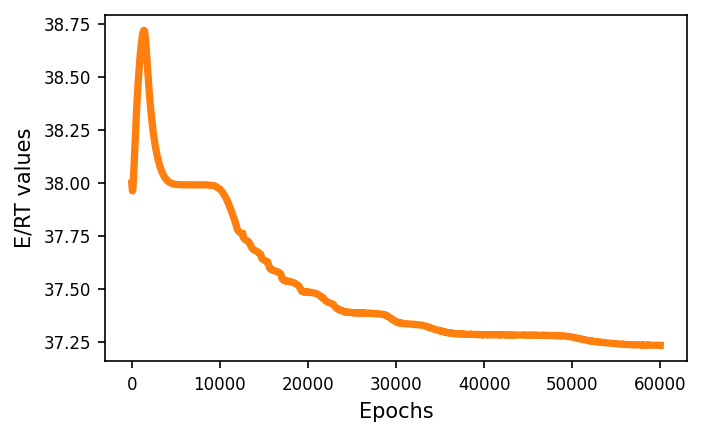

In [15]:
fig = plt.figure(figsize=(5, 3), dpi=150)
plt.plot(lambda2_list, 'tab:orange', linewidth='3.5')
plt.xticks(size='8')
plt.yticks(size='8')
plt.xlabel('Epochs')
plt.ylabel('E/RT values')
#plt.savefig('' + 'ERT_evolution_real' + '.pdf', format="pdf", bbox_inches="tight")